# MÔ HÌNH HÓA DỮ LIỆU

***Đặt ra bài toán*** : Dự đoán giá xe thông qua các thuộc tính khác của xe. Chúng ta cần hiểu điều gì ảnh hưởng đến giá xe và kết hợp càng nhiều thông tin vào mô hình.

Các biến tiềm năng có thể ảnh hưởng đến giá trị xe là:
- Brand, Type, Status, Fuel, Gearbox
- Year, CC, Kilometers, Seating Capacity

In [1]:
# Import các thư viện cần thiết
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
sns.set_theme()
from sklearn.preprocessing import StandardScaler

from sklearn.model_selection import train_test_split
from sklearn.model_selection import KFold
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import GridSearchCV

from sklearn.linear_model import LinearRegression
from sklearn.tree import DecisionTreeRegressor
from sklearn.neighbors import KNeighborsRegressor
from sklearn.ensemble import RandomForestRegressor
from sklearn.ensemble import ExtraTreesRegressor
from sklearn.neural_network import MLPRegressor



# Error Metrics
from sklearn.metrics import mean_squared_error

# Feature Selection
from sklearn.feature_selection import SelectKBest
from sklearn.feature_selection import chi2, f_regression


import warnings
warnings.simplefilter('ignore')

# Read data

In [2]:
csv_file_path = 'cars_info_preprocessed.csv'
dataframe = pd.read_csv(csv_file_path)
dataframe.head(5)


,ID,Name,Price,Brand,Model,Variant,Series,Year,Kilometers,Type,Gearbox,Fuel,Status,CC,Color,Seating Capacity
0,11530130,2010 Toyota Rukus Build 2 AZE151R,9999,Toyota,Rukus,Build 2,AZE151R,2010,263000,Wagon,Automatic,Unleaded Petrol,Used,2362,Grey,5
1,12190570,2021 Mercedes-Benz V 250 D Avantgarde MWB 447 ...,117990,Mercedes-Benz,V,250 D Avantgarde MWB,447 MY21,2021,19,Wagon,Automatic,Diesel,New In Stock,2143,Black,7
2,12321855,2021 Mercedes-Benz Valente 116 CDI MWB RWD 447...,79990,Mercedes-Benz,Valente,116 CDI MWB RWD,447 MY21,2021,24,Wagon,Automatic,Diesel,New In Stock,2143,Black,8
3,12346971,2010 Mercedes-Benz E250 CDI Avantgarde 207,34990,Mercedes-Benz,E250,CDI Avantgarde,207,2010,120579,Cabriolet,Automatic,Diesel,Used,2143,Black,4
4,12363884,2016 Holden Cruze CD JH MY16,15990,Holden,Cruze,CD,JH MY16,2016,72506,Sportswagon,Automatic,Unleaded Petrol,Used,1796,White,5


Dự đoán giá tiền của xe dựa trên Year, Kilometers, CC, Status, Seating Capacity, Brand, Type

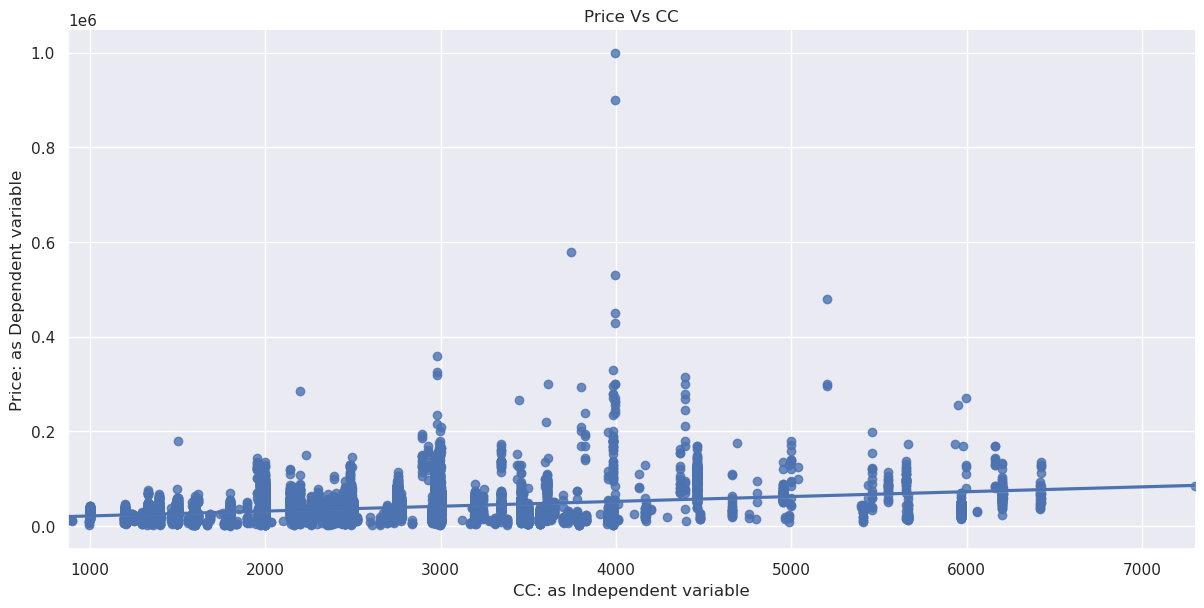

In [3]:
df = dataframe.drop(columns = ['Name','Model','Variant','Series','Color'])
df = df.set_index('ID')

# Thay thế những giá trị có kiểu dữ liệu str thành int
def replace_element(column_name):
    values = df[column_name].unique()
    for i in range(len(values)):
        df[column_name] = df[column_name].replace(values[i],i+1)
    
    
replace_element('Gearbox')
replace_element('Fuel')
replace_element('Brand')
replace_element('Type')
replace_element('Status')

sns.lmplot(x='CC',y='Price',data=df,aspect=2,height=6)
plt.xlabel('CC: as Independent variable')
plt.ylabel('Price: as Dependent variable')
plt.title('Price Vs CC')
plt.show()

In [4]:
df.describe().round(3)

,Price,Brand,Year,Kilometers,Type,Gearbox,Fuel,Status,CC,Seating Capacity
count,17048.000,17048.000,17048.000,17048.000,17048.000,17048.000,17048.000,17048.000,17048.000,17048.000
mean,36777.778,9.157,2015.481,103231.402,6.084,1.147,1.872,1.066,2491.830,5.116
std,30305.015,7.820,4.722,80413.131,7.464,0.365,0.917,0.328,881.986,1.122
min,1000.000,1.000,1989.000,1.000,1.000,1.000,1.000,1.000,875.000,2.000
25%,18800.000,3.000,2013.000,44502.250,1.000,1.000,1.000,1.000,1987.000,5.000
50%,29990.000,8.000,2016.000,88454.000,4.000,1.000,2.000,1.000,2354.000,5.000
75%,45990.000,14.000,2019.000,148873.500,6.000,1.000,2.000,1.000,2981.000,5.000
max,999000.000,59.000,2022.000,2700000.000,56.000,5.000,7.000,3.000,7300.000,14.000


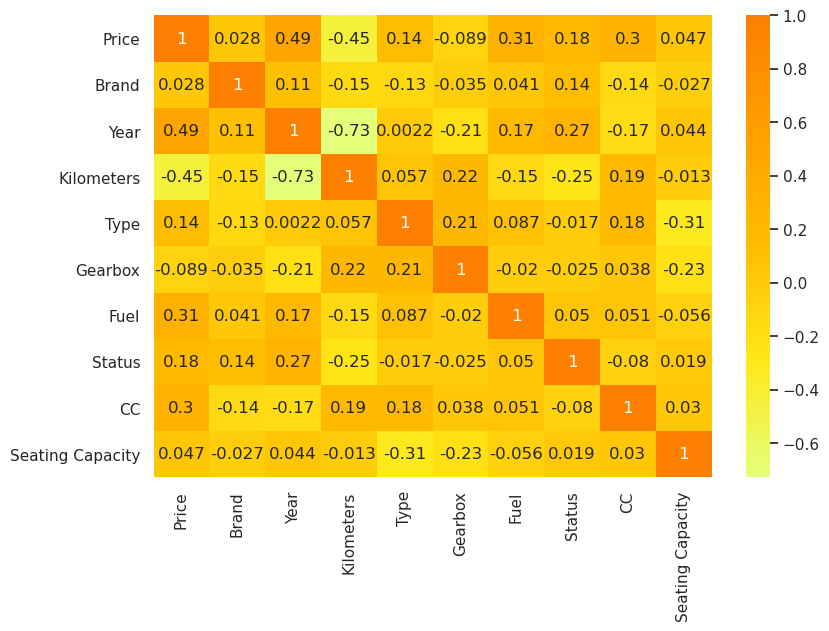

In [5]:
# Biểu đồ tương quan 
plt.figure(figsize = (9,6))
corr = df.corr()
sns.heatmap(corr, cmap = 'Wistia', annot= True)
plt.show()

không có mối tương quan giữa các biến.

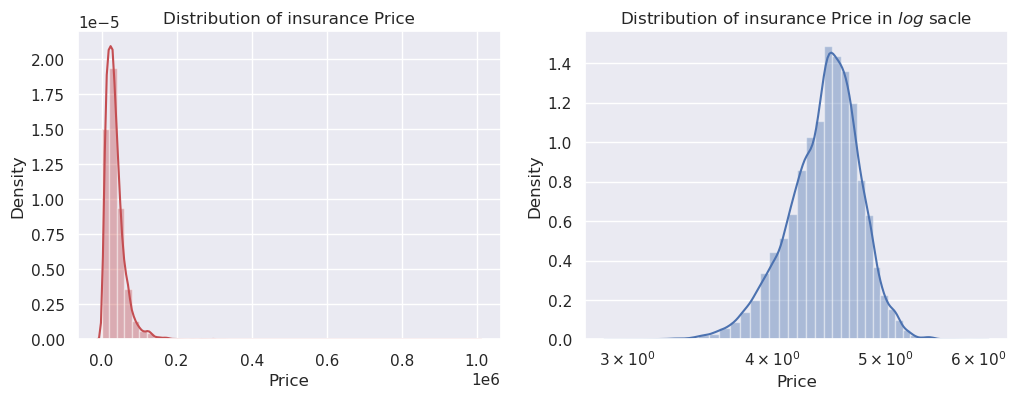

In [6]:
f= plt.figure(figsize=(12,4))

ax=f.add_subplot(121)
sns.distplot(df['Price'],bins=50,color='r',ax=ax)
ax.set_title('Distribution of insurance Price')

ax=f.add_subplot(122)
sns.distplot(np.log10(df['Price']),bins=40,color='b',ax=ax)
ax.set_title('Distribution of insurance Price in $log$ sacle')
ax.set_xscale('log')
plt.show()

In [7]:
X = df[df.columns.difference(['Price'])]
y = df['Price']

Sử dụng hàm **SelectKBest** của thư viện **sklearn** để xác định thuộc tính nào ảnh hưởng nhiều nhất đến **Price**

In [8]:
bestfeatures = SelectKBest(k=9, score_func=f_regression)
fit = bestfeatures.fit(X,y)
dfscores = pd.DataFrame(fit.scores_)
dfcolumns = pd.DataFrame(X.columns)
#concat two dataframes for better visualization 
featureScores = pd.concat([dfcolumns,dfscores],axis=1)
featureScores.columns = ['Specs','Score']  #naming the dataframe columns
featureScores.sort_values('Score',ascending=False).set_index('Specs')  #print all features

,Score
Specs,
Year,5329.264558
Kilometers,4268.082257
Fuel,1753.588208
CC,1663.796845
Status,567.661028
Type,319.511589
Gearbox,135.709202
Seating Capacity,37.143921
Brand,13.817415


Như vậy **Year** và **Kilometers** là 2 thuộc tính quan trọng ảnh hưởng đến giá tiền nhiều nhất

**Brand** và **Seating Capacity** là 2 thuộc tính ít ảnh hưởng nhất

Tiếp theo chúng ta chia nhỏ dữ liệu thành training data và test data

In [9]:
validation_size = 0.2

#In case the data is not dependent on the time series, then train and test split randomly
# seed = 7
X_train, X_test, Y_train, Y_test = train_test_split(X, y, test_size=validation_size, random_state=42)

#In case the data is not dependent on the time series, then train and test split should be done based on sequential sample
#This can be done by selecting an arbitrary split point in the ordered list of observations and creating two new datasets.
# train_size = int(len(X) * (1-validation_size))
# X_train, X_test = X[0:train_size], X[train_size:len(X)]
# Y_train, Y_test = y[0:train_size], y[train_size:len(X)]

Tiếp theo chúng ta lập 1 mảng chứa tên model và model đó.

In [10]:
models = []
models.append(('LR', LinearRegression()))
models.append(('KNN', KNeighborsRegressor(n_neighbors=5)))
models.append(('DTR', DecisionTreeRegressor(max_features=None, random_state=2, max_leaf_nodes=None)))
models.append(('RFR', RandomForestRegressor(n_estimators=256)))
models.append(('ETR', ExtraTreesRegressor(n_estimators=256)))

In [11]:
# scikit is moving away from mean_squared_error. 
# In order to avoid confusion, and to allow comparison with other models, we invert the final scores
scoring = 'neg_mean_squared_error'

names = []
kfold_results = []
test_mse = []
train_mse = []
train_score = []
test_score = []
for name, model in models:
    names.append(name)
    
    ## K Fold analysis:
    
    kfold = KFold()
    #converted mean square error to positive. The lower the beter
    cv_results = -1* cross_val_score(model, X_train, Y_train, cv=kfold, scoring=scoring)
    kfold_results.append(cv_results)
    

    # Full Training period
    res = model.fit(X_train, Y_train)
    train_score.append(model.score(X_train, Y_train))
    train_result = mean_squared_error(res.predict(X_train), Y_train)
    train_mse.append(train_result)
    
    
    # Test results
    test_score.append(model.score(X_test, Y_test))
    test_result = mean_squared_error(res.predict(X_test), Y_test)
    test_mse.append(test_result)
    

train_rmse = [x**(1/2) for x in train_mse]
test_rmse = [x**(1/2) for x in test_mse]

Tạo dataframe 

In [12]:
model_df = pd.DataFrame({'train_mse':train_mse,
                         'test_mse':test_mse,
                         'train_rmse':train_rmse,
                         'test_rmse':test_rmse,
                         'train_score':train_score,
                         'test_score':test_score
                        },index=names)
model_df

,train_mse,test_mse,train_rmse,test_rmse,train_score,test_score
LR,5.147890e+08,4.123203e+08,22688.961442,20305.671963,0.451750,0.506698
KNN,3.583081e+08,4.568187e+08,18929.026877,21373.316559,0.618402,0.453460
DTR,4.327879e+05,1.833147e+08,657.866184,13539.375101,0.999539,0.780681
RFR,2.238418e+07,1.367135e+08,4731.192189,11692.456668,0.976161,0.836435
ETR,4.330925e+05,1.163941e+08,658.097626,10788.610509,0.999539,0.860745


Vẽ biểu đồ xem model nào tốt nhất (biểu đồ càng thấp thì mô hình đó càng tốt)

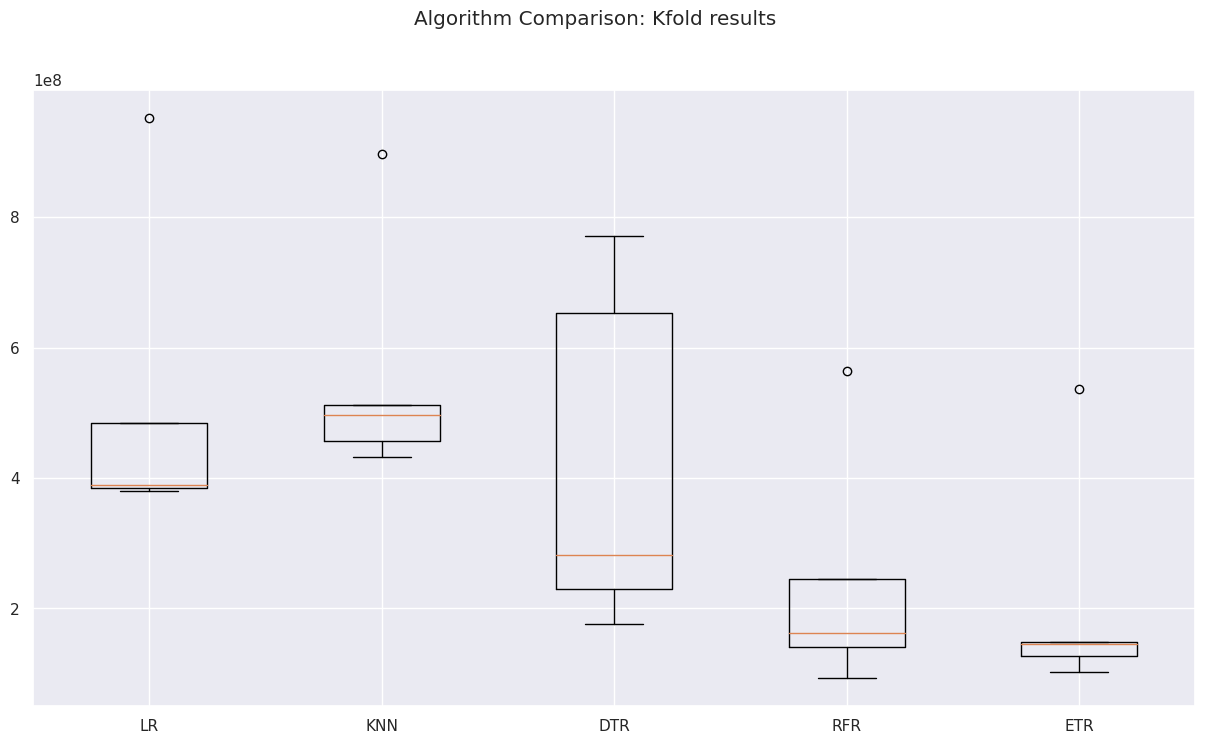

In [13]:
fig = plt.figure()
fig.suptitle('Algorithm Comparison: Kfold results')
ax = fig.add_subplot(111)
plt.boxplot(kfold_results)
ax.set_xticklabels(names)
fig.set_size_inches(15,8)
plt.show()

Chúng ta có thể thấy 2 mô hình **RandomForestRegressor** và **ExtraTreesRegressor** là 2 mô hình tốt nhất

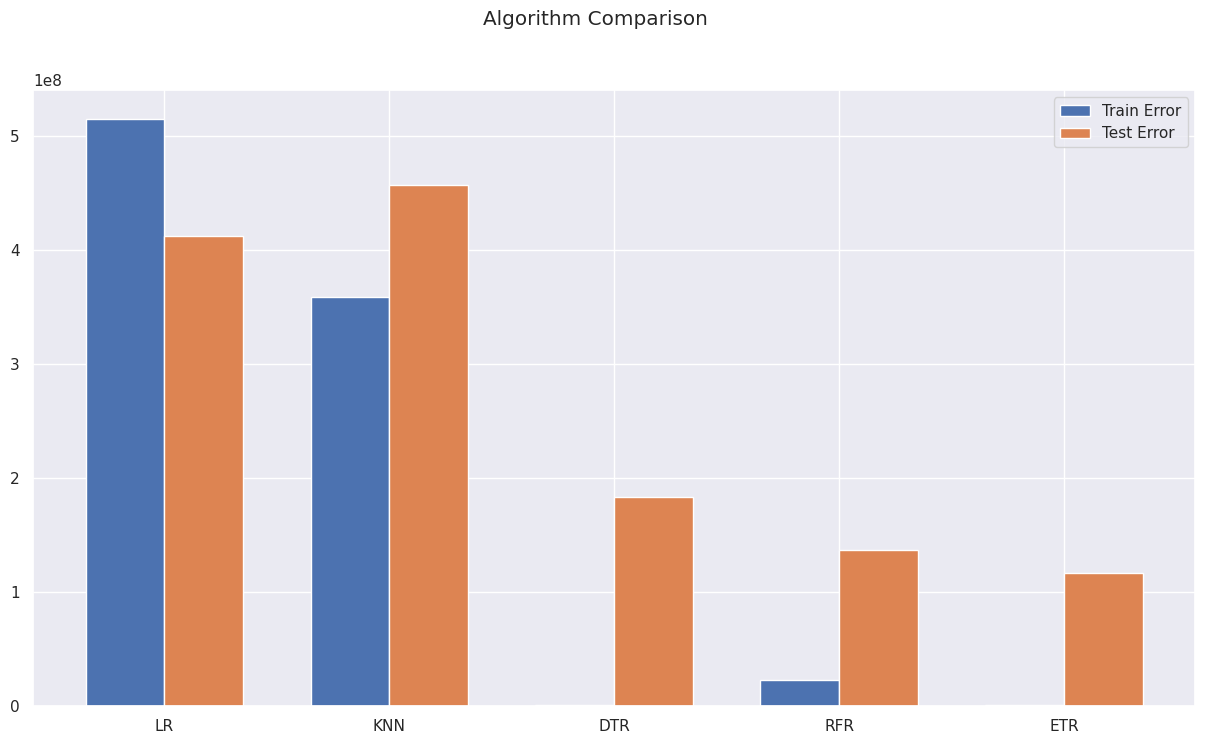

In [14]:
fig = plt.figure()

ind = np.arange(len(names))  # the x locations for the groups
width = 0.35  # the width of the bars

fig.suptitle('Algorithm Comparison')
ax = fig.add_subplot(111)
plt.bar(ind - width/2, train_mse,  width=width, label='Train Error')
plt.bar(ind + width/2, test_mse, width=width, label='Test Error')
fig.set_size_inches(15,8)
plt.legend()
ax.set_xticks(ind)
ax.set_xticklabels(names)
plt.show()